# This notebook demonstrates final integration and normalization steps on augmetned single cell reference and bulk data before training buddi4 model from buddi_v2

In [1]:
import sys
import pathlib
import joblib
import subprocess
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import umap.umap_ as umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from matplotlib_venn import venn2, venn3
import seaborn as sns

import tensorflow as tf

2025-05-23 12:15:03.988464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 12:15:03.996819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748024104.006161 1681817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748024104.008970 1681817 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748024104.016602 1681817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
SAMPLE_ID_COL = 'sample_id'
STIM_COL = 'stim'
GENE_ID_COL = 'gene_ids'
TECH_COL = 'samp_type'

## Add buddi_v2 software to path

In [3]:
# Get the root directory of the analysis repository
REPO_ROOT = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()
REPO_ROOT = pathlib.Path(REPO_ROOT)
BUDDI_PATH = REPO_ROOT / "src"

sys.path.insert(0, str(BUDDI_PATH))

from buddi_v2.data import BuDDINData
from buddi_v2.plotting.plot_data import plot_data

## Pre-Processing Output

In [4]:
## Input data path
DATA_PATH = REPO_ROOT / 'examples' / 'example_data'
assert DATA_PATH.exists()
PREPROCESS_OUTPUT_PATH = DATA_PATH / 'preprocessed_data'
assert PREPROCESS_OUTPUT_PATH.exists(), f"Preprocessed data path {PREPROCESS_OUTPUT_PATH} does not exist."

PREPROCESS_SC_AUGMENTED_OUTPUT_PATH = PREPROCESS_OUTPUT_PATH / 'sc_augmented'
assert PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.exists()

CIBERSORTX_SIG_GENE_FILE = DATA_PATH / 'cibersort_liver' /\
    'CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job20_all-liver_0_cybersort_sig_inferred_refsample.bm.K999.txt'
assert CIBERSORTX_SIG_GENE_FILE.exists()

PREPROCESS_BULK_FORMAT_PATH = PREPROCESS_OUTPUT_PATH / 'bulk_formatted'
assert PREPROCESS_BULK_FORMAT_PATH.exists()

### Read cibersortx sig genes

In [5]:
cibersortx_sig_df = pd.read_csv(CIBERSORTX_SIG_GENE_FILE, sep='\t', header=0)
cibersortx_sig_genes = cibersortx_sig_df['NAME'].values.tolist()
print(f"{len(cibersortx_sig_genes)} signature genes from CIBERSORTx")

2194 signature genes from CIBERSORTx


### Read gene id pkl file for single cell and psuedobulk and find intersection

Number of bulk genes: 54352
Number of single cell genes: 13924
Number of genes in intersection of single cell and bulk: 12618
Number of CIBERSORTx signature genes dropped due to not in intersection: 284


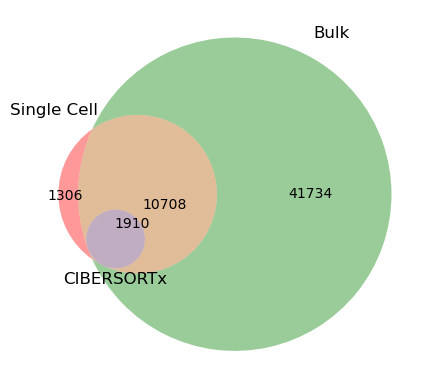

In [6]:
bulk_gene_file = PREPROCESS_BULK_FORMAT_PATH.glob('*_genes.pkl')
bulk_gene_file = list(bulk_gene_file)
assert len(bulk_gene_file) == 1, f"Expected one bulk gene file, found {len(bulk_gene_file)}"
bulk_genes = pd.read_pickle(bulk_gene_file[0])
print(f"Number of bulk genes: {len(bulk_genes)}")

sc_gene_file = PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.glob('*_genes.pkl')
sc_gene_file = list(sc_gene_file)
assert len(sc_gene_file) == 1, f"Expected one sc gene file, found {len(sc_gene_file)}"
sc_genes = pd.read_pickle(sc_gene_file[0])
print(f"Number of single cell genes: {len(sc_genes)}")

# Intersect the genes
sc_bulk_intersection_genes = set(sc_genes) & set(bulk_genes)
sc_bulk_intersection_genes = list(sc_bulk_intersection_genes)
print(f"Number of genes in intersection of single cell and bulk: {len(sc_bulk_intersection_genes)}")

# drop cibersortx signature genes that are not in the sc bulk intersection
cibersortx_drop_genes = set(cibersortx_sig_genes) - set(sc_bulk_intersection_genes)
print(f"Number of CIBERSORTx signature genes dropped due to not in intersection: {len(cibersortx_drop_genes)}")
cibersortx_sig_genes = set(cibersortx_sig_genes).intersection(sc_bulk_intersection_genes)
cibersortx_sig_genes = list(cibersortx_sig_genes)

venn3(
    [
        set(sc_genes),
        set(bulk_genes),
        set(cibersortx_sig_genes)
    ],
    set_labels=['Single Cell', 'Bulk', 'CIBERSORTx']
)

### Preprocessed Bulk

In [7]:
formatted_bulk_files = list(PREPROCESS_BULK_FORMAT_PATH.glob('*.h5ad'))
assert len(formatted_bulk_files) > 0, f"No formatted bulk files found in {PREPROCESS_BULK_FORMAT_PATH}"

processed_bulk = sc.read(formatted_bulk_files[0]) 

bulk_sample_ids = processed_bulk.obs[SAMPLE_ID_COL].unique()
n_bulk_samples = len(bulk_sample_ids)
print(f"Number of bulk samples: {n_bulk_samples}")

bulk_stims = processed_bulk.obs[STIM_COL].unique()
n_bulk_stims = len(bulk_stims)
print(f"Number of bulk stims: {n_bulk_stims}")

## Subset the bulk data to only include the intersection genes
processed_bulk = processed_bulk[
    :, 
    processed_bulk.var[GENE_ID_COL].isin(sc_bulk_intersection_genes)]

X_bulk_train = pd.DataFrame(
    processed_bulk.X,
    index=processed_bulk.obs[SAMPLE_ID_COL],
    columns=processed_bulk.var[GENE_ID_COL]
)

meta_bulk_train = processed_bulk.obs.loc[:,[SAMPLE_ID_COL, STIM_COL]]
meta_bulk_train['isTraining'] = 'Train'
meta_bulk_train['cell_prop_type'] = 'bulk'
meta_bulk_train['cell_type'] = 'bulk'
meta_bulk_train['samp_type'] = 'bulk'

Number of bulk samples: 49
Number of bulk stims: 2


### Preprocessed single cell

In [8]:
pseudobulk_files = list(PREPROCESS_SC_AUGMENTED_OUTPUT_PATH.glob('*_splits.pkl'))
assert len(pseudobulk_files) > 0, f"No pseudobulk files found in {PREPROCESS_SC_AUGMENTED_OUTPUT_PATH}"

pattern = re.compile(r'^(.*)_((?:Train)|(?:Test))_((?:meta)|(?:prop)|(?:pseudo))_splits\.pkl$')

# Temporary dictionary to group by sample_id
temp_dict = defaultdict(lambda: defaultdict(dict))

for path in pseudobulk_files:
    file = path.name
    match = pattern.match(file)
    if match:
        sample_id, datasplit, datatype = match.groups()
        temp_dict[datasplit][sample_id][datatype] = path

# Organizing the sorted results
grouped_files = {
    "Train": {"meta": [], "prop": [], "pseudo": []},
    "Test": {"meta": [], "prop": [], "pseudo": []}
}

# Sort within each datasplit by sample_id and organize the lists
for datasplit in ["Train", "Test"]:
    sorted_samples = sorted(temp_dict[datasplit].keys())  # Sort by sample_id
    for sample_id in sorted_samples:
        for datatype in ["meta", "prop", "pseudo"]:
            print(f"Found {datatype} file for {datasplit} sample {sample_id}")
            if datatype in temp_dict[datasplit][sample_id]:
                grouped_files[datasplit][datatype].append(temp_dict[datasplit][sample_id][datatype])

# Train datasplit
meta_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['meta']]
)
meta_sc_train['isTraining'] = 'Train'
Y_sc_train = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Train']['prop']]
)
X_sc_train = pd.concat(
    [pd.read_pickle(file).loc[:, sc_bulk_intersection_genes] for file in grouped_files['Train']['pseudo']]
)

_n_samples = meta_sc_train[SAMPLE_ID_COL].nunique()
print(f"Number of train single cell samples: {_n_samples}")

_n_stims = meta_sc_train[STIM_COL].nunique()
print(f"Number of train single cell stims: {_n_stims}")

# Test datasplit
meta_sc_test = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Test']['meta']]
)
meta_sc_test['isTraining'] = 'Test'
Y_sc_test = pd.concat(
    [pd.read_pickle(file) for file in grouped_files['Test']['prop']]
)
X_sc_test = pd.concat(
    [pd.read_pickle(file).loc[:, sc_bulk_intersection_genes] for file in grouped_files['Test']['pseudo']]
)

_n_samples = meta_sc_test[SAMPLE_ID_COL].nunique()
print(f"Number of test single cell samples: {_n_samples}")
_n_stims = meta_sc_test[STIM_COL].nunique()
print(f"Number of test single cell stims: {_n_stims}")

Found meta file for Train sample liver_30-M-5_male
Found prop file for Train sample liver_30-M-5_male
Found pseudo file for Train sample liver_30-M-5_male
Found meta file for Test sample liver_18-F-51_female
Found prop file for Test sample liver_18-F-51_female
Found pseudo file for Test sample liver_18-F-51_female
Number of train single cell samples: 1
Number of train single cell stims: 1
Number of test single cell samples: 1
Number of test single cell stims: 1


### Concatenate X, Y, Perform Gene Feature Selection

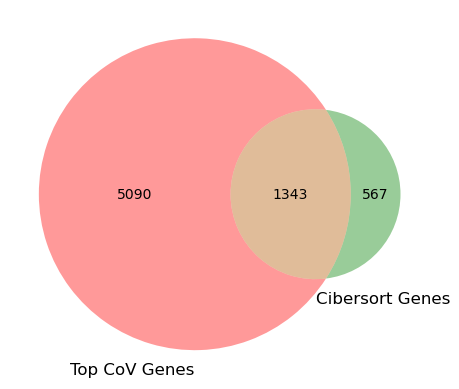

(3649, 7000)


In [9]:
# Generate place holder for bulk proportion (not used)
Y_bulk_dummy = pd.DataFrame(
    np.zeros((X_bulk_train.shape[0], Y_sc_train.shape[1])),
    columns=Y_sc_train.columns
)

X_concat = pd.concat([X_bulk_train, X_sc_train, X_sc_test])
Y_concat = pd.concat([Y_bulk_dummy, Y_sc_train, Y_sc_test])
meta_concat = pd.concat([meta_bulk_train, meta_sc_train, meta_sc_test])

# save gene and cell type names
X_gene_names = X_concat.columns.to_list()
Y_cell_type_names = Y_concat.columns.to_list()

## get the top variable genes
X_colmean = X_concat.values.mean(axis=0) # mean across samples
X_colvar = X_concat.values.var(axis=0) # variance across samples
# coefficient of variation which is the var to mean ratio
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001)) 

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False

gene_df = pd.DataFrame(X_gene_names, columns=['gene'])

# start with top 7000 genes by CoV
initial_count = 7000
while not num_genes_found:
    # retrieve the top initial_count genes by CoV
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    # get gene names from idx_top
    top_gene_df = gene_df.iloc[idx_top]

    # produce the union of the top genes and the cibersort genes
    CoV_only = np.union1d(top_gene_df, cibersortx_sig_genes)

    # check if the union is 7000
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        # if not decrement the top CoV gene to retrieve by 1
        # in the next iteration, there will be two possibilities
        # 1. the union will have one less gene due to the removed gene being only in the CoV genes
        # 2. the union will have the same number of genes as this iteration due to the removed 
        #    gene being also present in CIBERSORTx genes
        # keep running this loop until the union has 7000 genes
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]
venn2([set(gene_df.values.flatten()), 
       set(cibersortx_sig_genes)], 
       set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

feature_select_genes = np.union1d(gene_df, cibersortx_sig_genes)

# to numpy matrix
X = X_concat.loc[:,feature_select_genes].to_numpy()
print(X.shape)

Y = Y_concat.to_numpy()

### Normalize Expression

In [10]:
## library size normalization
expected_libsizes = 1e6

libsizes = np.sum(X, axis=1, keepdims=True)
libsizes[libsizes == 0] = 1
X_norm = X / libsizes * expected_libsizes

## normalize within sample
clip_upper = np.quantile(X_norm, 0.9)
X_full = np.clip(X_norm, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)

### Construct Data container

In [ ]:
train_data = BuDDINData(
    X = X_full,
    y = Y,
    meta = meta_concat,
    gene_names= feature_select_genes,
    cell_type_names = Y_cell_type_names,
    split_column= 'isTraining',
    encode_fields = [ # tell the data class to one-hot encode these fields
        SAMPLE_ID_COL,
        STIM_COL,
        TECH_COL
    ]
)

To access data: 

In [12]:
(
    _X, _y, _label, _stim, _samp_type, _meta
    ) = train_data.get()
print(f"X shape: {_X.shape}")
print(f"y shape: {_y.shape}")
print(f"label shape: {_label.shape}")
print(f"stim shape: {_stim.shape}")
print(f"samp_type shape: {_samp_type.shape}")
print(f"meta shape: {_meta.shape}")

X shape: (3649, 7000)
y shape: (3649, 8)
label shape: (3649, 6)
stim shape: (3649, 51)
samp_type shape: (3649, 2)
meta shape: (3649, 2)


To access select modalities:

In [13]:
_X = train_data.get(['X'])
print(f"X shape: {_X.shape}")

X shape: (3649, 7000)


To select for specific data

In [14]:
_X, _meta = train_data.reset_query().query(
    isTraining='Train'
).get(('X', 'meta'))
print(f"X shape: {_X.shape}")
_meta.head()

X shape: (1849, 7000)


,sample_id,stim,isTraining,cell_prop_type,cell_type,samp_type
0,Liver_56,male,Train,bulk,bulk,bulk
1,Liver_46,male,Train,bulk,bulk,bulk
2,Liver_8,female,Train,bulk,bulk,bulk
3,Liver_14,male,Train,bulk,bulk,bulk
4,Liver_9,female,Train,bulk,bulk,bulk


In [15]:
_X, _meta = train_data.reset_query().query(
    isTraining='Train',
    stim='female'
).get(('X', 'meta'))
print(f"X shape: {_X.shape}")
_meta.head()

X shape: (14, 7000)


,sample_id,stim,isTraining,cell_prop_type,cell_type,samp_type
2,Liver_8,female,Train,bulk,bulk,bulk
4,Liver_9,female,Train,bulk,bulk,bulk
9,Liver_6,female,Train,bulk,bulk,bulk
11,Liver_27,female,Train,bulk,bulk,bulk
17,Liver_33,female,Train,bulk,bulk,bulk


To up/down-sample:

In [16]:
_X, _meta = train_data.reset_query().query(
    isTraining='Train',
    stim='male'
).get(
    ('X', 'meta'),
    n_samples=100,
    replace=True,
    random_state=42
)
print(f"X shape: {_X.shape}")
_meta.head()

X shape: (100, 7000)


,sample_id,stim,isTraining,cell_prop_type,cell_type,samp_type
1140,30-M-5,male,Train,single_celltype,NK,sc_ref
1473,30-M-5,male,Train,single_celltype,hepatocyte,sc_ref
874,30-M-5,male,Train,random,random,sc_ref
1308,30-M-5,male,Train,single_celltype,hepatic_sinusoid,sc_ref
1144,30-M-5,male,Train,single_celltype,NK,sc_ref


### Visualize Data

Plot everything

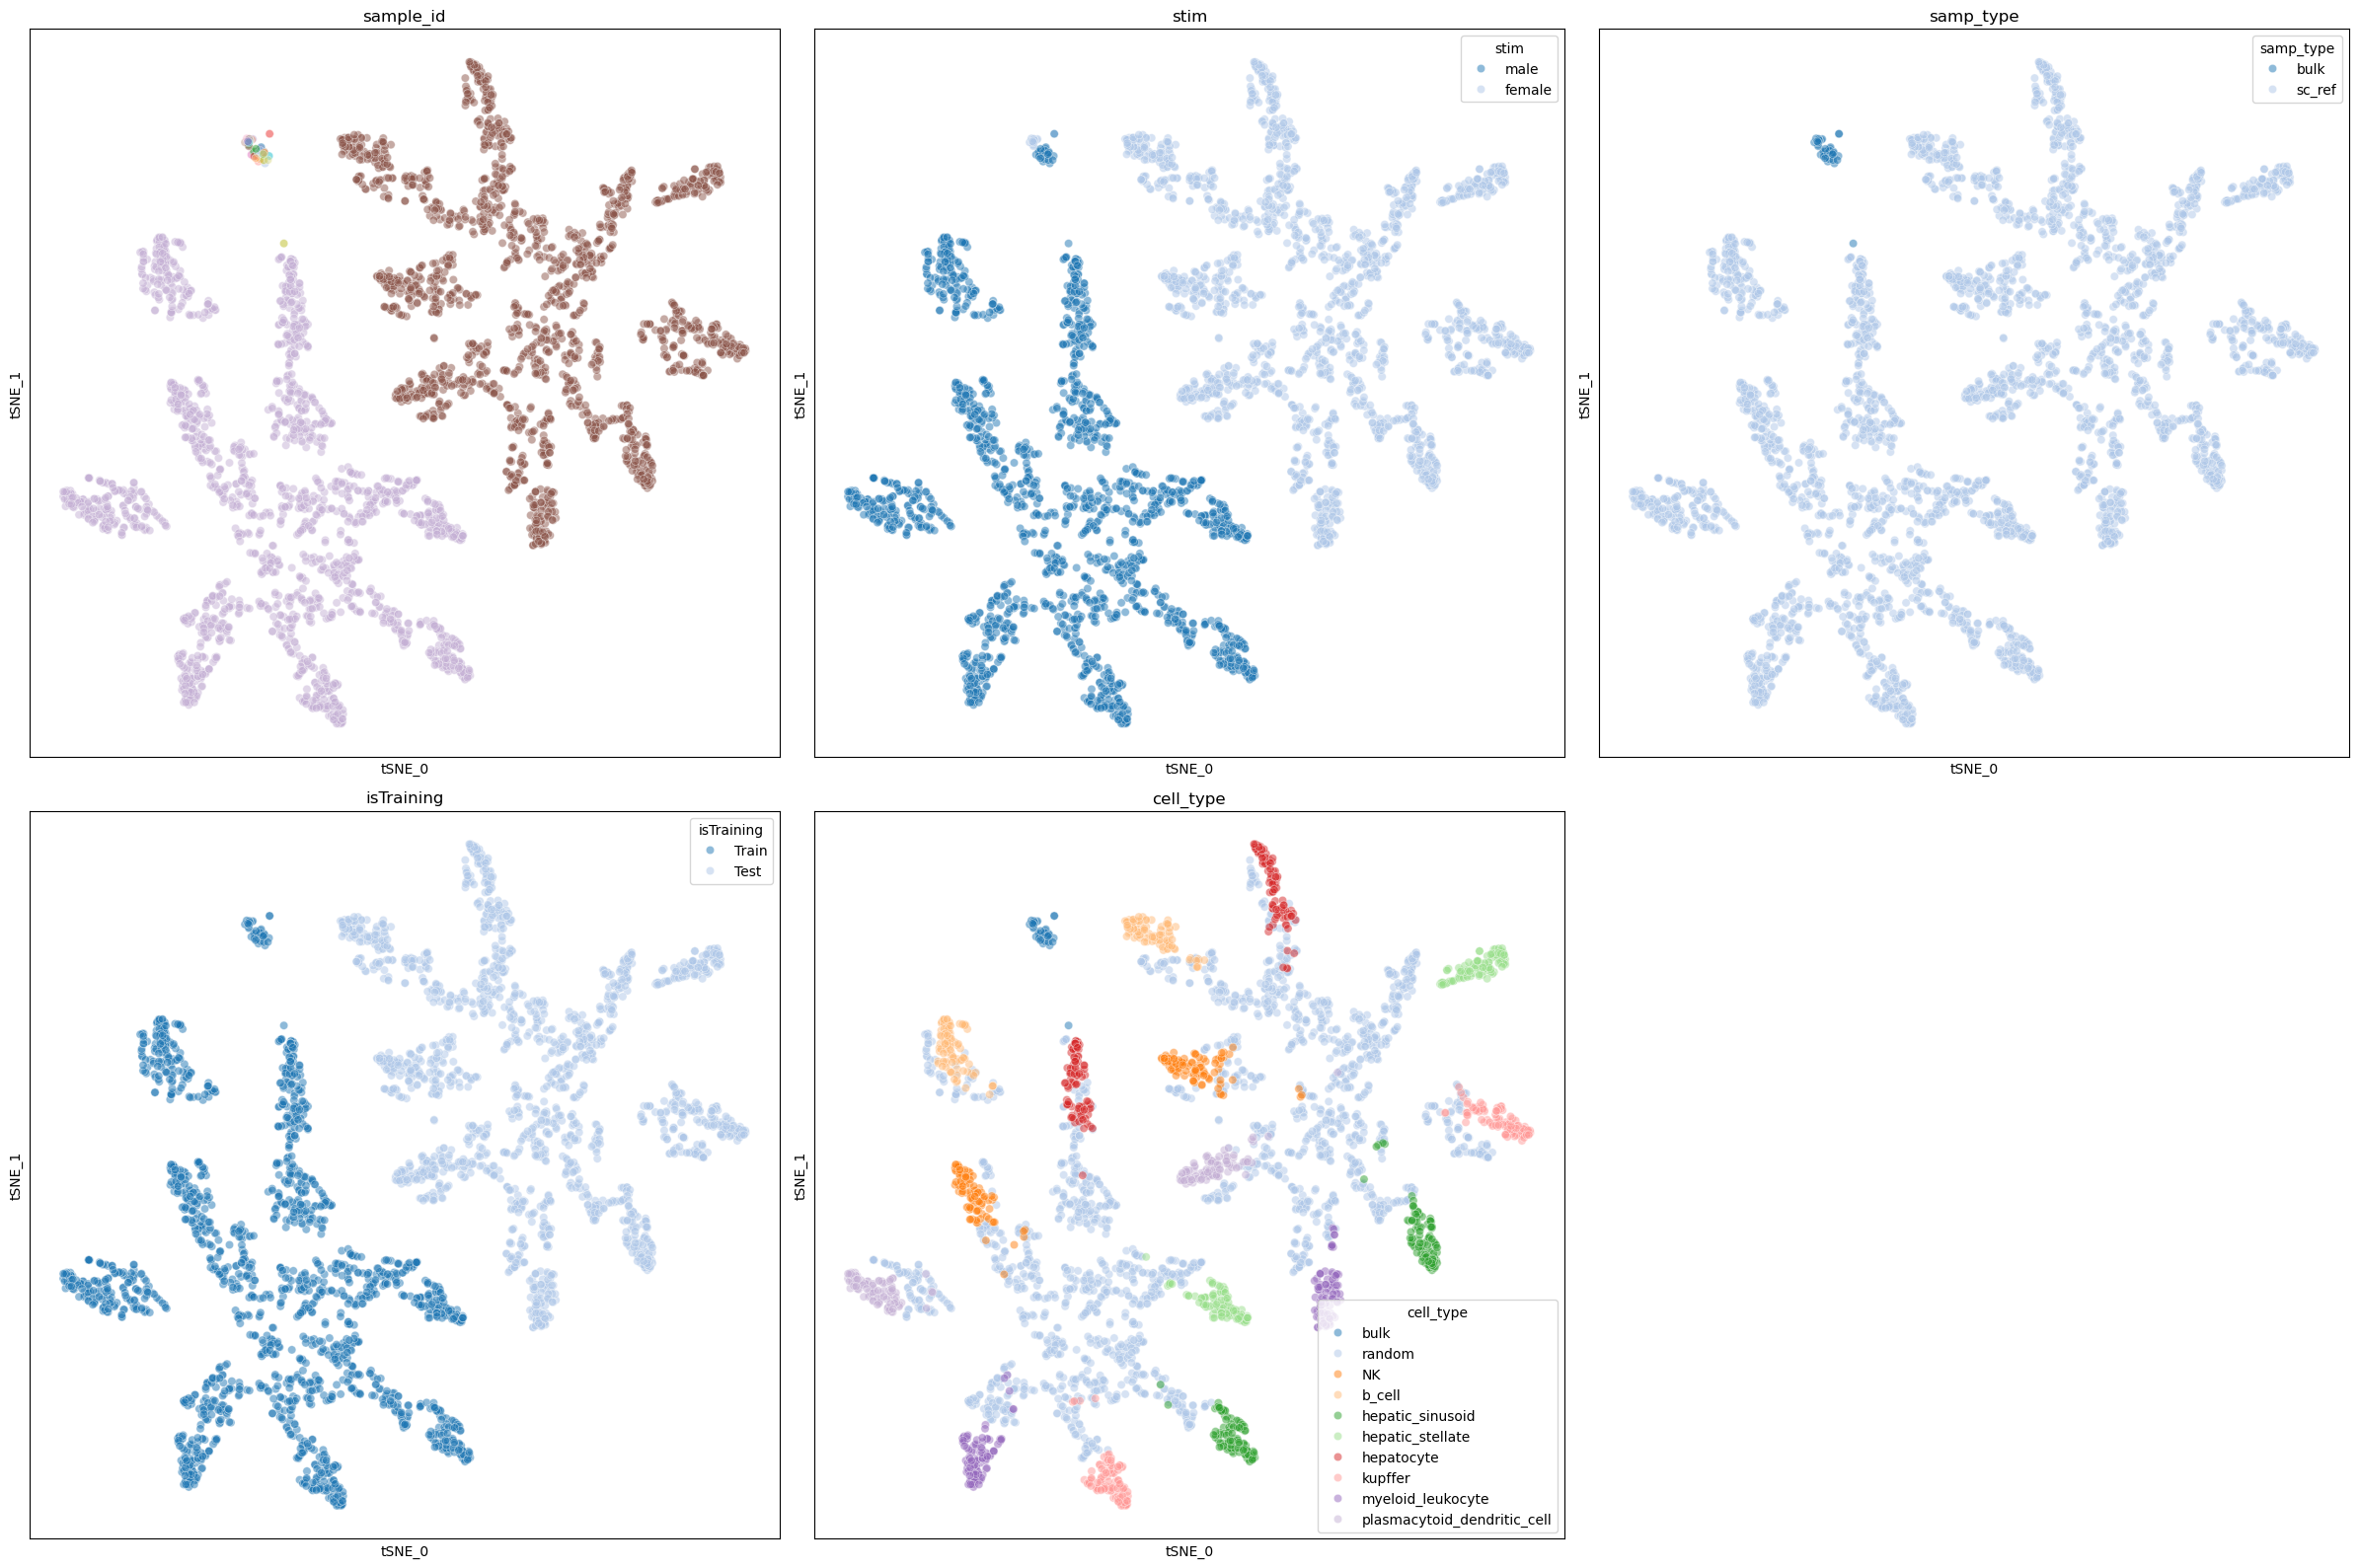

In [17]:
train_data.reset_query().plot(
    color_by=[
        SAMPLE_ID_COL, 
        STIM_COL,
        TECH_COL, 
        train_data.split_column,
        train_data.ct_column
    ],    
    panel_width=8,
    show_plot=True
)

Plot only the train split

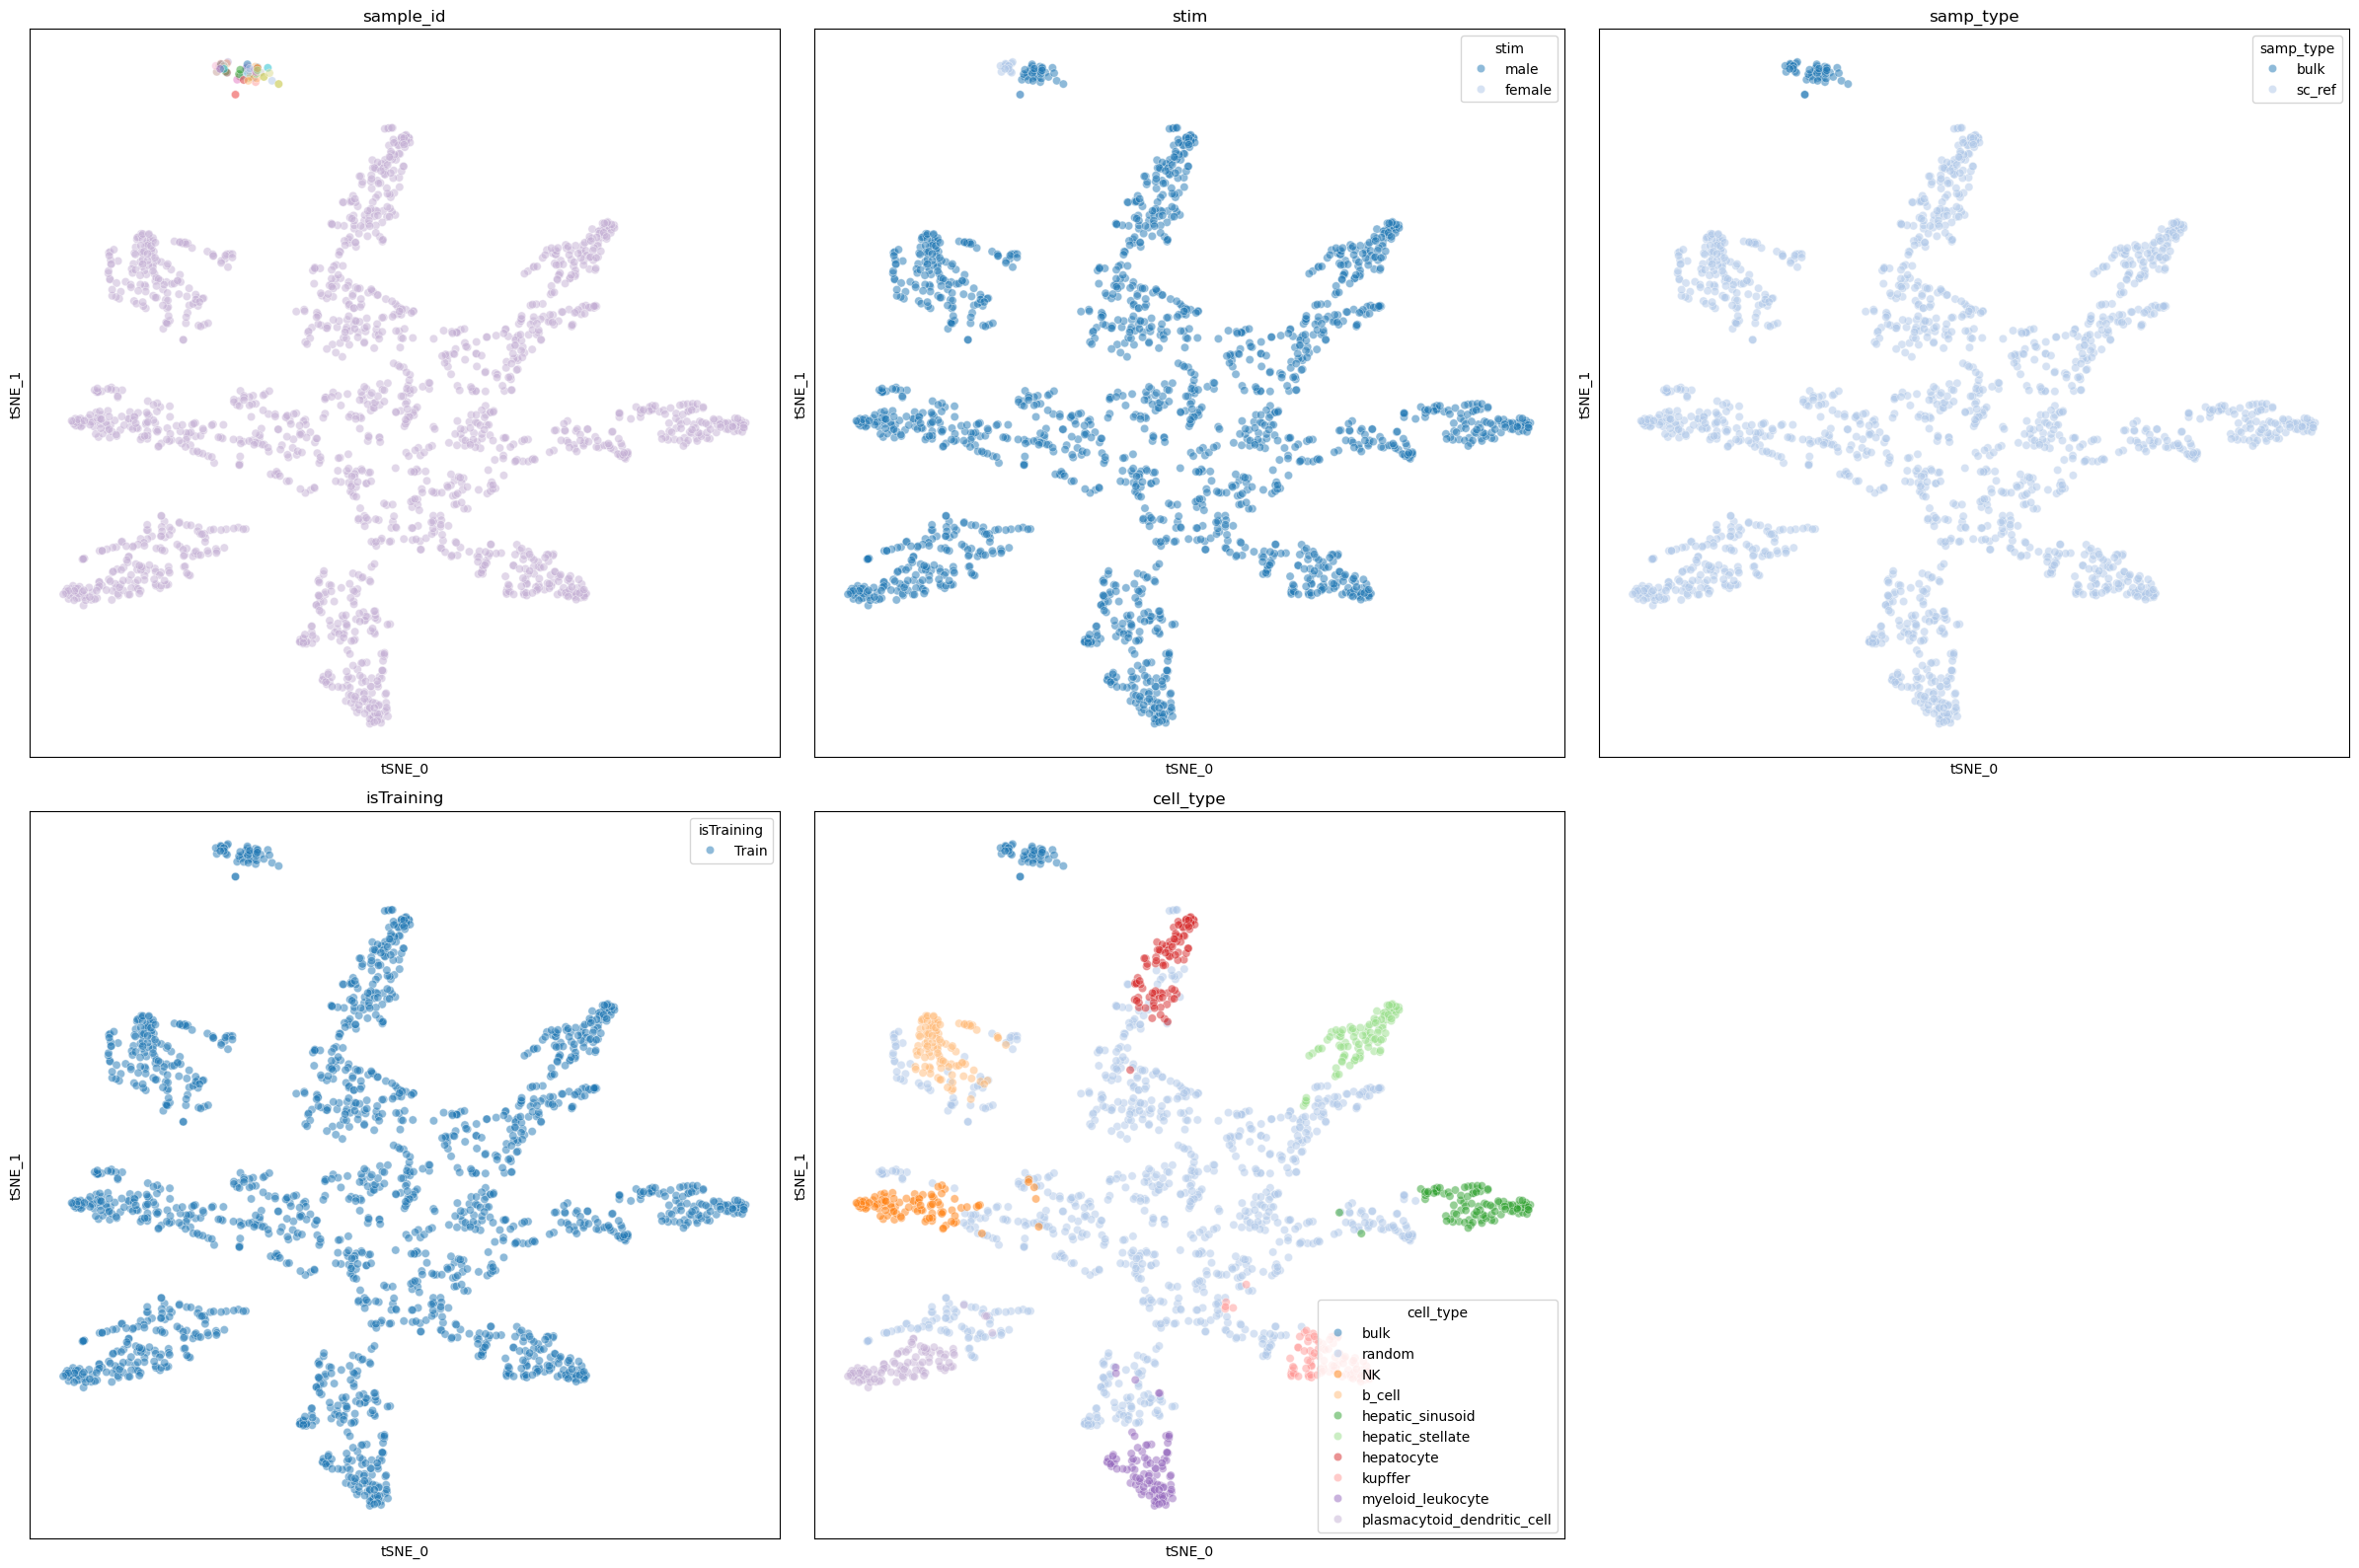

In [18]:
train_data.reset_query().query(
    isTraining = 'Train'
).plot(
    color_by=[
        SAMPLE_ID_COL, 
        STIM_COL,
        TECH_COL, 
        train_data.split_column,
        train_data.ct_column
    ],    
    panel_width=8,
    show_plot=True
)

### Save the data class for later use

In [19]:
_ = joblib.dump(
    train_data.reset_query(), 
    DATA_PATH / "buddi4_data.pkl")